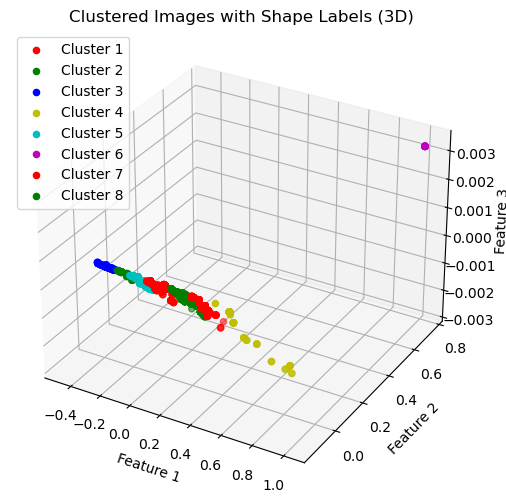

Cluster 5:
Filenames: ['0001.jpg', '0002.jpg', '0006.jpg', '0007.jpg', '0023.jpg', '0028.jpg', '0051.jpg', '0055.jpg', '0060.jpg', '0066.jpg', '0071.jpg', '0072.jpg', '0076.jpg', '0080.jpg', '0081.jpg', '0086.jpg', '0090.jpg', '0102.jpg', '0103.jpg', '0108.jpg', '0111.jpg', '0118.jpg', '0124.jpg', '0126.jpg', '0127.jpg', '0130.jpg', '0141.jpg', '0143.jpg', '0149.jpg', '0158.jpg', '0168.jpg', '0170.jpg', '0192.jpg', '0193.jpg', '0201.jpg', '0203.jpg', '0209.jpg', '0211.jpg', '0213.jpg', '0220.jpg', '0221.jpg', '0223.jpg', '0225.jpg', '0228.jpg', '0229.jpg', '0232.jpg', '0235.jpg', '0237.jpg', '0241.jpg', '0242.jpg', '0247.jpg', '0256.jpg', '0271.jpg', '0277.jpg', '0278.jpg', '0279.jpg', '0283.jpg', '0293.jpg', '0295.jpg', '0298.jpg', '0304.jpg', '0315.jpg', '0326.jpg', '0328.jpg', '0330.jpg', '0356.jpg', '0362.jpg', '0365.jpg', '0379.jpg', '0386.jpg', '0402.jpg', '0415.jpg', '0420.jpg', '0422.jpg', '0423.jpg', '0424.jpg', '0431.jpg', '0434.jpg', '0438.jpg', '0446.jpg', '0465.jpg', '0469

In [1]:
import os
import cv2
import numpy as np
from scipy.stats import hmean
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from shutil import copyfile
import zipfile
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

def extract_images_from_zip(zip_file_path, extract_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

def extract_contour_features(image):
    try:
        # Convert image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Apply Gaussian blur and Canny edge detection
        edges = cv2.Canny(cv2.GaussianBlur(gray, (1, 1), 0), 50, 100)
        # Find contours in the edge-detected image
        contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Extract contour-based features
        features = []
        for contour in contours:
            # Calculate contour area and convex hull area
            area = cv2.contourArea(contour)
            hull = cv2.convexHull(contour)
            hull_area = cv2.contourArea(hull)
            # Calculate solidity
            solidity = area / hull_area if hull_area != 0 else 0
            # Calculate other features
            perimeter = cv2.arcLength(contour, True)
            vertices = len(cv2.approxPolyDP(contour, 0.006 * perimeter, True))
            compactness = np.square(area) / perimeter
            harmonic_mean_ratio = hmean([vertices / area if area != 0 else 0, vertices / perimeter if perimeter != 0 else 0])
            features.append([compactness, harmonic_mean_ratio, solidity])
        
        return np.array(features)
    except Exception as e:
        print(f"Error extracting contour features: {e}")
        return None

def find_optimal_num_clusters(X):
    def find_optimal_num_clusters(X):
    # Compute the linkage matrix
      Z = linkage(X, 'ward')

    # Plot the dendrogram
      plt.figure(figsize=(15, 5))
    dendrogram(Z)
    plt.title('Dendrogram')
    plt.xlabel('Image Index')
    plt.ylabel('Distance')
    plt.show()
    

def group_images_by_clustering(image_dir):
    # Create lists to store image filenames and their corresponding features
    filenames = []
    features_list = []

    # Iterate through each image in the directory
    for filename in os.listdir(image_dir):
        if filename.endswith((".jpg", ".png")):  # Assuming images are in JPEG or PNG format
            try:
                # Read the image
                image_path = os.path.join(image_dir, filename)
                image = cv2.imread(image_path)

                # Extract contour-based features
                features = extract_contour_features(image)

                if features is not None:
                    # Append filename and features to lists
                    filenames.append(filename)
                    # Append features for each contour
                    for contour_features in features:
                        compactness, harmonic_mean_ratio, solidity = contour_features
                        features_list.append([compactness, harmonic_mean_ratio, solidity])
                else:
                    print(f"Skipping image {filename} due to contour extraction error.")
            except Exception as e:
                print(f"Error processing image {filename}: {e}")

    # Convert features list to numpy array
    X = np.array(features_list)

    # Apply hierarchical clustering
    num_clusters = 8  # Adjust the number of clusters as needed
    clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    labels = clustering.fit_predict(X)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=3)  # 3D plot
    reduced_features = pca.fit_transform(X)

    # Plot the clustered images in 3D with shape labels
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    for i in range(num_clusters):
        ax.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], reduced_features[labels == i, 2],
                   c=colors[i % len(colors)], label=f'Cluster {i+1}')
    ax.set_title('Clustered Images with Shape Labels (3D)')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.legend()
    plt.show()

    # Create a dictionary to store image families
    image_families = {}
    for filename, label in zip(filenames, labels):
        if label not in image_families:
            image_families[label] = [filename]
        else:
            image_families[label].append(filename)

    # Return image families and image-label pairs
    image_label_pairs = [(filename, label) for filename, label in zip(filenames, labels)]
    return image_families, image_label_pairs

def move_images_to_folders(image_dir, image_label_pairs):
    # Create folders for each cluster
    for label in set(label for _, label in image_label_pairs):
        cluster_dir = os.path.join(image_dir, f"Cluster_{label+1}")
        os.makedirs(cluster_dir, exist_ok=True)

    # Move images to corresponding folders
    for filename, label in image_label_pairs:
        src_path = os.path.join(image_dir, filename)
        dst_path = os.path.join(image_dir, f"Cluster_{label+1}", filename)
        copyfile(src_path, dst_path)

# Directory containing images
zip_file_path = "E7-images.zip"

# Directory to extract images
extract_dir = "extracted_images"

# Extract images from the ZIP file
extract_images_from_zip(zip_file_path, extract_dir)

# Group extracted images by clustering
image_families, image_label_pairs = group_images_by_clustering(extract_dir)

# Move images to corresponding folders
move_images_to_folders(extract_dir, image_label_pairs)

# Print the grouped families
for cluster_id, filenames in image_families.items():
    print(f"Cluster {cluster_id + 1}:")
    print("Filenames:", filenames)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

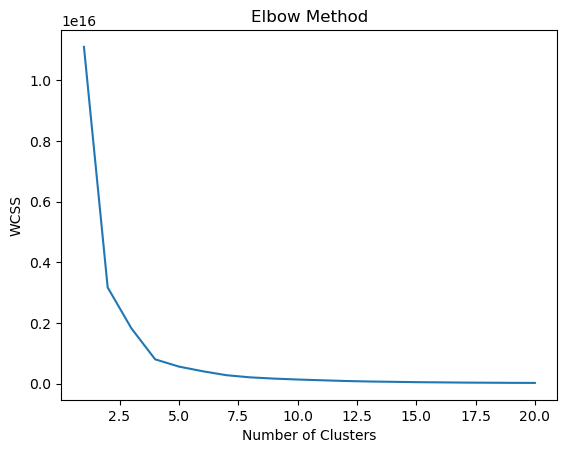

Enter the optimal number of clusters: 8


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


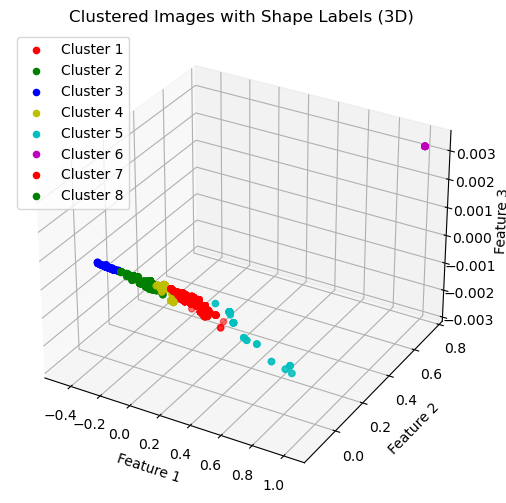

Cluster 8:
Filenames: ['0001.jpg', '0002.jpg', '0006.jpg', '0010.jpg', '0013.jpg', '0047.jpg', '0054.jpg', '0056.jpg', '0060.jpg', '0066.jpg', '0071.jpg', '0076.jpg', '0081.jpg', '0083.jpg', '0093.jpg', '0097.jpg', '0102.jpg', '0111.jpg', '0117.jpg', '0124.jpg', '0129.jpg', '0131.jpg', '0132.jpg', '0143.jpg', '0149.jpg', '0152.jpg', '0158.jpg', '0160.jpg', '0168.jpg', '0175.jpg', '0191.jpg', '0196.jpg', '0203.jpg', '0204.jpg', '0209.jpg', '0213.jpg', '0217.jpg', '0220.jpg', '0221.jpg', '0225.jpg', '0226.jpg', '0228.jpg', '0229.jpg', '0235.jpg', '0237.jpg', '0247.jpg', '0257.jpg', '0268.jpg', '0271.jpg', '0277.jpg', '0279.jpg', '0283.jpg', '0293.jpg', '0307.jpg', '0315.jpg', '0329.jpg', '0330.jpg', '0351.jpg', '0354.jpg', '0356.jpg', '0362.jpg', '0365.jpg', '0378.jpg', '0386.jpg', '0402.jpg', '0405.jpg', '0415.jpg', '0422.jpg', '0423.jpg', '0431.jpg', '0434.jpg', '0438.jpg', '0448.jpg', '0478.jpg', '0481.jpg', '0483.jpg', '0485.jpg', '0495.jpg', '0502.jpg', '0516.jpg', '0519.jpg', '0531

In [8]:
import os
import cv2
import numpy as np
from scipy.stats import hmean
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from shutil import copyfile
import zipfile

def extract_images_from_zip(zip_file_path, extract_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Directory containing the zip file
zip_file_path = "E7-images.zip"
# Directory to extract the images
extract_dir = "E7-images"
# Extract images from the zip file
extract_images_from_zip(zip_file_path, extract_dir)

def extract_contour_features(image):
    try:
        # Convert image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Apply Gaussian blur and Canny edge detection
        edges = cv2.Canny(cv2.GaussianBlur(gray, (1, 1), 0), 50, 100)
        # Find contours in the edge-detected image
        contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Extract contour-based features
        features = []
        for contour in contours:
            # Calculate contour area and convex hull area
            area = cv2.contourArea(contour)
            hull = cv2.convexHull(contour)
            hull_area = cv2.contourArea(hull)
            # Calculate solidity
            solidity = area / hull_area if hull_area != 0 else 0
            # Calculate other features
            perimeter = cv2.arcLength(contour, True)
            vertices = len(cv2.approxPolyDP(contour, 0.006 * perimeter, True))
            compactness = np.square(area) / perimeter
            harmonic_mean_ratio = hmean([vertices / area if area != 0 else 0, vertices / perimeter if perimeter != 0 else 0])
            features.append([compactness, harmonic_mean_ratio, solidity])
        
        return np.array(features)
    except Exception as e:
        print(f"Error extracting contour features: {e}")
        return None

def classify_shape(compactness, harmonic_mean_ratio, solidity):
    # Example classification logic
    if compactness > 0.5 and solidity > 0.7:
        return "Circle"
    elif compactness < 0.4 and solidity < 0.6:
        return "Triangle"
    else:
        return "Other"

def find_optimal_num_clusters(X):
    wcss = []
    max_clusters = 20  # Maximum number of clusters to try
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, max_clusters+1), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

def group_images_by_clustering(image_dir):
    # Create lists to store image filenames and their corresponding features
    filenames = []
    features_list = []

    # Iterate through each image in the directory
    for filename in os.listdir(image_dir):
        if filename.endswith((".jpg", ".png")):  # Assuming images are in JPEG or PNG format
            try:
                # Read the image
                image_path = os.path.join(image_dir, filename)
                image = cv2.imread(image_path)

                # Extract contour-based features
                features = extract_contour_features(image)

                if features is not None:
                    # Append filename and features to lists
                    filenames.append(filename)
                    # Append features for each contour
                    for contour_features in features:
                        compactness, harmonic_mean_ratio, solidity = contour_features
                        features_list.append([compactness, harmonic_mean_ratio, solidity])
                else:
                    print(f"Skipping image {filename} due to contour extraction error.")
            except Exception as e:
                print(f"Error processing image {filename}: {e}")

    # Convert features list to numpy array
    X = np.array(features_list)

    # Find the optimal number of clusters using the elbow method
    find_optimal_num_clusters(X)

    # Determine the final number of clusters based on the elbow method
    num_clusters = int(input("Enter the optimal number of clusters: "))

    # Apply K-means clustering with the final number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(X)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=3)  # 3D plot
    reduced_features = pca.fit_transform(X)

    # Plot the clustered images in 3D with shape labels
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    for i in range(num_clusters):
        ax.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], reduced_features[labels == i, 2],
                   c=colors[i % len(colors)], label=f'Cluster {i+1}')
    ax.set_title('Clustered Images with Shape Labels (3D)')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.legend()
    plt.show()

    # Create a dictionary to store image families
    image_families = {}
    for filename, label in zip(filenames, labels):
        if label not in image_families:
            image_families[label] = [filename]
        else:
            image_families[label].append(filename)

    # Return image families and image-label pairs
    image_label_pairs = [(filename, label) for filename, label in zip(filenames, labels)]
    return image_families, image_label_pairs

def move_images_to_folders(image_dir, image_label_pairs):
    # Create folders for each cluster
    for label in set(label for _, label in image_label_pairs):
        cluster_dir = os.path.join(image_dir, f"Cluster_{label+1}")
        os.makedirs(cluster_dir, exist_ok=True)

# Directory containing images
image_dir = "E7-images"

# Group images by clustering
image_families, image_label_pairs = group_images_by_clustering(image_dir)

# Move images to corresponding folders
move_images_to_folders(image_dir, image_label_pairs)

# Print the grouped families
for cluster_id, filenames in image_families.items():
    print(f"Cluster {cluster_id + 1}:")
    print("Filenames:", filenames)


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


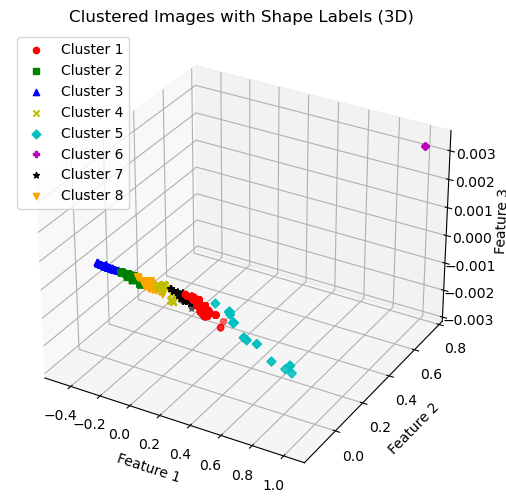

Cluster 8:
Filenames: ['0001.jpg', '0002.jpg', '0006.jpg', '0010.jpg', '0013.jpg', '0047.jpg', '0054.jpg', '0056.jpg', '0060.jpg', '0066.jpg', '0071.jpg', '0076.jpg', '0081.jpg', '0083.jpg', '0093.jpg', '0097.jpg', '0102.jpg', '0111.jpg', '0117.jpg', '0124.jpg', '0129.jpg', '0131.jpg', '0132.jpg', '0143.jpg', '0149.jpg', '0152.jpg', '0158.jpg', '0160.jpg', '0168.jpg', '0175.jpg', '0191.jpg', '0196.jpg', '0203.jpg', '0204.jpg', '0209.jpg', '0213.jpg', '0217.jpg', '0220.jpg', '0221.jpg', '0225.jpg', '0226.jpg', '0228.jpg', '0229.jpg', '0235.jpg', '0237.jpg', '0247.jpg', '0257.jpg', '0268.jpg', '0271.jpg', '0277.jpg', '0279.jpg', '0283.jpg', '0293.jpg', '0307.jpg', '0315.jpg', '0329.jpg', '0330.jpg', '0351.jpg', '0354.jpg', '0356.jpg', '0362.jpg', '0365.jpg', '0378.jpg', '0386.jpg', '0402.jpg', '0405.jpg', '0415.jpg', '0422.jpg', '0423.jpg', '0431.jpg', '0434.jpg', '0438.jpg', '0448.jpg', '0478.jpg', '0481.jpg', '0483.jpg', '0485.jpg', '0495.jpg', '0502.jpg', '0516.jpg', '0519.jpg', '0531

In [7]:
import os
import cv2
import numpy as np
from scipy.stats import hmean
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from shutil import copyfile
import zipfile

def extract_images_from_zip(zip_file_path, extract_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Directory containing the zip file
zip_file_path = "E7-images.zip"
# Directory to extract the images
extract_dir = "E7-images"
# Extract images from the zip file
extract_images_from_zip(zip_file_path, extract_dir)

def extract_contour_features(image):
    try:
        # Convert image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Apply Gaussian blur and Canny edge detection
        edges = cv2.Canny(cv2.GaussianBlur(gray, (1, 1), 0), 50, 100)
        # Find contours in the edge-detected image
        contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Extract contour-based features
        features = []
        for contour in contours:
            # Calculate contour area and convex hull area
            area = cv2.contourArea(contour)
            hull = cv2.convexHull(contour)
            hull_area = cv2.contourArea(hull)
            # Calculate solidity
            solidity = area / hull_area if hull_area != 0 else 0
            # Calculate other features
            perimeter = cv2.arcLength(contour, True)
            vertices = len(cv2.approxPolyDP(contour, 0.006 * perimeter, True))
            compactness = np.square(area) / perimeter
            harmonic_mean_ratio = hmean([vertices / area if area != 0 else 0, vertices / perimeter if perimeter != 0 else 0])
            features.append([compactness, harmonic_mean_ratio, solidity])
        
        return np.array(features)
    except Exception as e:
        print(f"Error extracting contour features: {e}")
        return None

def group_images_by_clustering(image_dir):
    # Create lists to store image filenames, features, and classifications
    filenames = []
    features_list = []

    # Iterate through each image in the directory
    for filename in os.listdir(image_dir):
        if filename.endswith((".jpg", ".png")):  # Assuming images are in JPEG or PNG format
            try:
                # Read the image
                image_path = os.path.join(image_dir, filename)
                image = cv2.imread(image_path)

                # Extract contour-based features
                features = extract_contour_features(image)

                if features is not None:
                    # Append filename and features to lists
                    filenames.append(filename)
                    # Append features for each contour
                    for contour_features in features:
                        compactness, harmonic_mean_ratio, solidity = contour_features
                        features_list.append([compactness, harmonic_mean_ratio, solidity])
                else:
                    print(f"Skipping image {filename} due to contour extraction error.")
            except Exception as e:
                print(f"Error processing image {filename}: {e}")

    # Convert features list to numpy array
    X = np.array(features_list)

    # Determine the final number of clusters
    num_clusters = 8

    # Apply K-means clustering with the final number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(X)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=3)  # 3D plot
    reduced_features = pca.fit_transform(X)

    # Plot the clustered images in 3D with shape labels
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'orange']  # 8 distinct colors
    markers = ['o', 's', '^', 'x', 'D', 'P', '*', 'v']  # 8 distinct markers
    for i in range(num_clusters):
        ax.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], reduced_features[labels == i, 2],
                   c=colors[i % len(colors)], marker=markers[i % len(markers)], label=f'Cluster {i+1}')
    ax.set_title('Clustered Images with Shape Labels (3D)')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.legend()
    plt.show()

    # Create a dictionary to store image families
    image_families = {}
    for filename, label in zip(filenames, labels):
        if label not in image_families:
            image_families[label] = [filename]
        else:
            image_families[label].append(filename)

    # Return image families and image-label pairs
    image_label_pairs = [(filename, label) for filename, label in zip(filenames, labels)]
    return image_families, image_label_pairs

def move_images_to_folders(image_dir, image_label_pairs):
    # Create folders for each cluster
    for label in set(label for _, label in image_label_pairs):
        cluster_dir = os.path.join(image_dir, f"Cluster_{label+1}")
        os.makedirs(cluster_dir, exist_ok=True)

    # Move images to corresponding folders
    for filename, label in image_label_pairs:
        src_path = os.path.join(image_dir, filename)
        dst_dir = os.path.join(image_dir, f"Cluster_{label+1}")
        dst_path = os.path.join(dst_dir, filename)
        copyfile(src_path, dst_path)

# Directory containing images
image_dir = "E7-images"

# Group images by clustering
image_families, image_label_pairs = group_images_by_clustering(image_dir)

# Move images to corresponding folders
move_images_to_folders(image_dir, image_label_pairs)

# Print the grouped families
for cluster_id, filenames in image_families.items():
    print(f"Cluster {cluster_id + 1}:")
    print("Filenames:", filenames)
